<a href="https://colab.research.google.com/github/ramon-m-machado/training-notes/blob/main/SimpleDLFapesp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Drive


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# ler e processar imagens
import imageio.v2 as iio
from PIL import Image
import cv2 as cv

# para acessar as imagens no diretorio
import os

# regex para extrair a classe do nome do arquivo
import re

In [4]:
# imports para o k fold
from sklearn.model_selection import StratifiedKFold # Cross Validation Function.
# like top_k_categorical_accuracy but for labels integer-encoded
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy

from sklearn import metrics

In [5]:
# imports data augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [6]:
#imports spiderplot
import plotly.graph_objects as go

import pandas as pd

In [7]:
# import confusion matrix
from plotly.subplots import make_subplots

from matplotlib.colors import LinearSegmentedColormap

In [8]:
# imports para as metricas
from sklearn.metrics import classification_report

### Tamanho da imagem

In [9]:
size = 250
border = 150

### Ler imagens

In [10]:
base_path = '/content/drive/MyDrive/Colab Notebooks/FAPESP/images/'
path = [base_path + 'Control/', base_path + 'Serial/', base_path + 'Streak/']
trainingImages = []
labels = []
for i in range(3):
    for file in os.listdir(path[i]):
        img = np.array(Image.open(path[i]+file)) #.convert('L'))
        imgCut = img[border:-border,border:-border]
        imgResize = cv.resize(imgCut, dsize = (size,size))
        trainingImages.append(imgResize)

        a = re.search(r"\d-\d*_.M_P1C(\d+)", file)
        labels.append(a.groups()[0])

In [11]:
labels = np.array(labels, dtype=np.int8) -1

In [12]:
trainingImages = np.array(trainingImages)

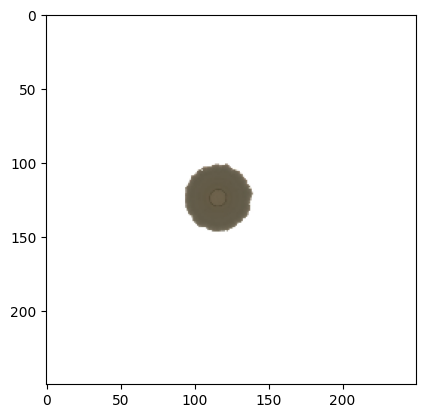

In [13]:
plt.imshow(trainingImages[0])

### Data Augmentation

In [14]:
input_shape = (size,size,3)

In [15]:
dataAugmentation = tf.keras.models.Sequential([

  tf.keras.layers.RandomRotation(factor=0.05,fill_mode='nearest', input_shape = input_shape),

  tf.keras.layers.RandomZoom(0.05)]
)

###Modelo

In [16]:
def simple_dl():
  model = tf.keras.models.Sequential()

  model.add(dataAugmentation)
  model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  return model

###Metricas

In [17]:
def top_2k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=5)

def true_positive(y_true, y_pred):
  return tf.reduce_sum(tf.cast(tf.math.equal(y_true, y_pred), dtype=tf.float32), axis=0)


In [18]:
metrics = ['accuracy', top_2k_accuracy, top_3k_accuracy, top_5k_accuracy]
#tf.keras.metrics.Precision(), tf.keras.metrics.Recall()

###Salvar modelo

In [19]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/FAPESP/model.ckpt"

# callback para salvar os pesos do modelo
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

### K fold

In [20]:
n_split = 5

skf = StratifiedKFold(n_splits=n_split, random_state=42, shuffle=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [21]:
k = 0
loss = np.empty((n_split))
accuracys = np.empty((n_split))
top_2k = np.empty((n_split))
top_3k = np.empty((n_split))
top_5k = np.empty((n_split))
tp = np.empty((n_split))
cf_matrix = np.empty((n_split,10,10)) # matriz de confusao para cada k
y_pred_all = []
labels_test_all = []
y_pred_prob = []

for (train_index, test_index) in skf.split(trainingImages, labels):

  model = simple_dl()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics= metrics)

  print(f'\n\n\t FOLD: {k+1}/{n_split}', end="\n\n")

  model.fit(trainingImages[train_index],
            labels[train_index], epochs=80,
            validation_data=(trainingImages[test_index], labels[test_index]),
            callbacks=[callback, cp_callback],
            batch_size=64,
            verbose=False)

  loss[k], accuracys[k], top_2k[k], top_3k[k], top_5k[k] = model.evaluate(trainingImages[test_index], labels[test_index])

  # probabilities
  y_pred =  model.predict(trainingImages[test_index])
  # todas probabilidades
  y_pred_prob.append(y_pred)
  # predicted class
  y_pred_labels = np.argmax(y_pred, axis=1)

  # salvar as predicoes e o esperado para cada k, para o 'classification_report'
  y_pred_all.append(y_pred_labels)
  labels_test_all.append(labels[test_index])

  tp[k] = true_positive(labels[test_index], y_pred_labels).numpy()

  cf_matrix[k] = tf.math.confusion_matrix(
                labels[test_index],
                y_pred_labels,
                num_classes=None,
                weights=None,
                dtype=float,
                name=None
              )
  k+=1



	 FOLD: 1/5

2/2 [==============================] - 0s 12ms/step


	 FOLD: 2/5

2/2 [==============================] - 0s 8ms/step


	 FOLD: 3/5

2/2 [==============================] - 0s 10ms/step


	 FOLD: 4/5

2/2 [==============================] - 0s 7ms/step


	 FOLD: 5/5

2/2 [==============================] - 0s 20ms/step - loss: 2.4159 - accuracy: 0.7500 - top_2k_accuracy: 0.8000 - top_3k_accuracy: 0.8250 - top_5k_accuracy: 0.9250


2/2 [==============================] - 0s 6ms/step


In [22]:
cf_geral = np.zeros((10,10))
for i in range(n_split):
  cf_geral += np.array(cf_matrix[i])

In [23]:
print('Cross-Validation Metrics\n')
print('Accuracy: %.3f +/- %.3f' %(np.mean(accuracys), np.std(accuracys)))
print('Loss:     %.3f +/- %.3f' %(np.mean(loss), np.std(loss)))
print('Top 2k:   %.3f +/- %.3f' %(np.mean(top_2k), np.std(top_2k)))
print('Top 3k:   %.3f +/- %.3f' %(np.mean(top_3k), np.std(top_3k)))
print('Top 5k:   %.3f +/- %.3f' %(np.mean(top_5k), np.std(top_5k)))

Cross-Validation Metrics

Accuracy: 0.780 +/- 0.019
Loss:     1.302 +/- 0.589
Top 2k:   0.860 +/- 0.034
Top 3k:   0.895 +/- 0.037
Top 5k:   0.945 +/- 0.024


### Matriz de confusao

In [24]:
classes = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]

In [25]:
colors = ["#005F73","#0A9396","#94D2BD","#E9D8A6","#EE9B00","#CA6702","#BB3E03","#AE2012","#9B2226"]
cmap = LinearSegmentedColormap.from_list("", colors)


#### Matriz para cada k-fold

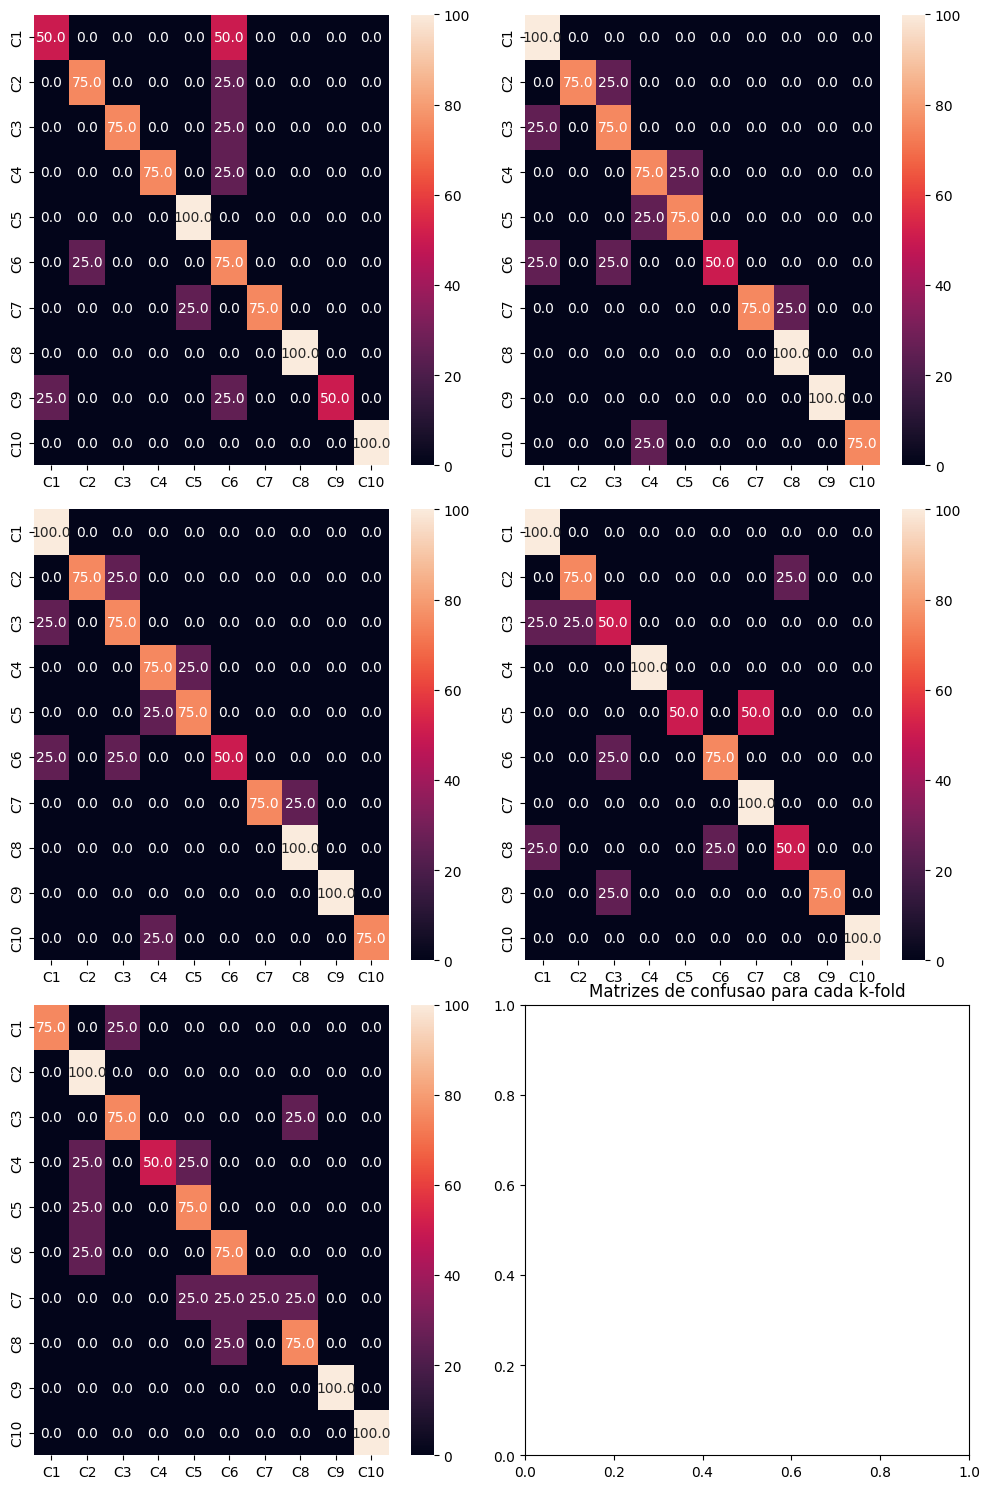

In [26]:
# subplot com 3 linhas e 2 colunas cada (uso 5)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# plotar as 4 matrizes de confusao dos 4 primeiros folds
for i in range(2):
  for j in range(2):
    sn.heatmap(cf_matrix[i+j]*100 / np.max(cf_matrix[i+j]),
      annot=True, fmt=".1f",
      annot_kws={"size": 10},
      xticklabels=classes,
      yticklabels=classes,
      #cmap=cmap,
      ax=axs[i,j])

# plotar a matriz de confusao do ultimo fold
sn.heatmap(cf_matrix[4]*100 / np.max(cf_matrix[4]),
  annot=True, fmt=".1f",
  annot_kws={"size": 10},
  xticklabels=classes,
  yticklabels=classes, ax=axs[2,0])

# Ajustar espaco
plt.tight_layout()
plt.title("Matrizes de confusao para cada k-fold")
plt.show()

#### Matriz geral

In [27]:
colors_error = ["#94D2BD","#E9D8A6","#EE9B00","#CA6702","#BB3E03","#AE2012","#9B2226","#005F73"]
cmap_error = LinearSegmentedColormap.from_list("", colors_error)

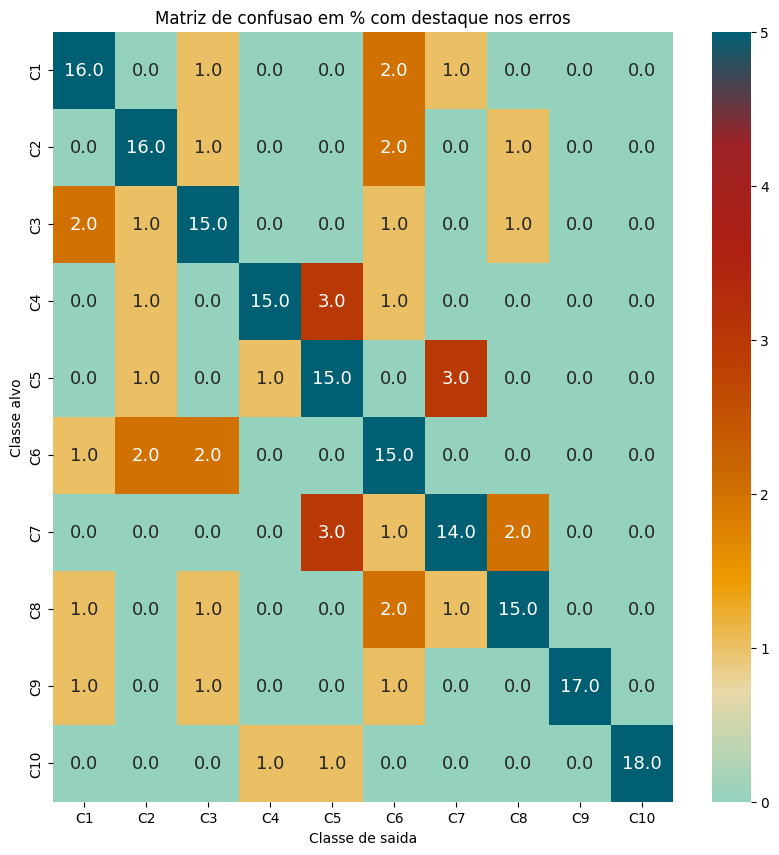

In [28]:
plt.figure(figsize=(10,10))
sn.heatmap(cf_geral,
           annot=True,
           fmt="",
           annot_kws={"size": 13},
           xticklabels=classes,
           yticklabels=classes,
           cmap=cmap_error,
           vmin=0,
           vmax=5)

plt.title("Matriz de confusao em % com destaque nos erros")
plt.xlabel("Classe de saida")
plt.ylabel("Classe alvo")

plt.show()

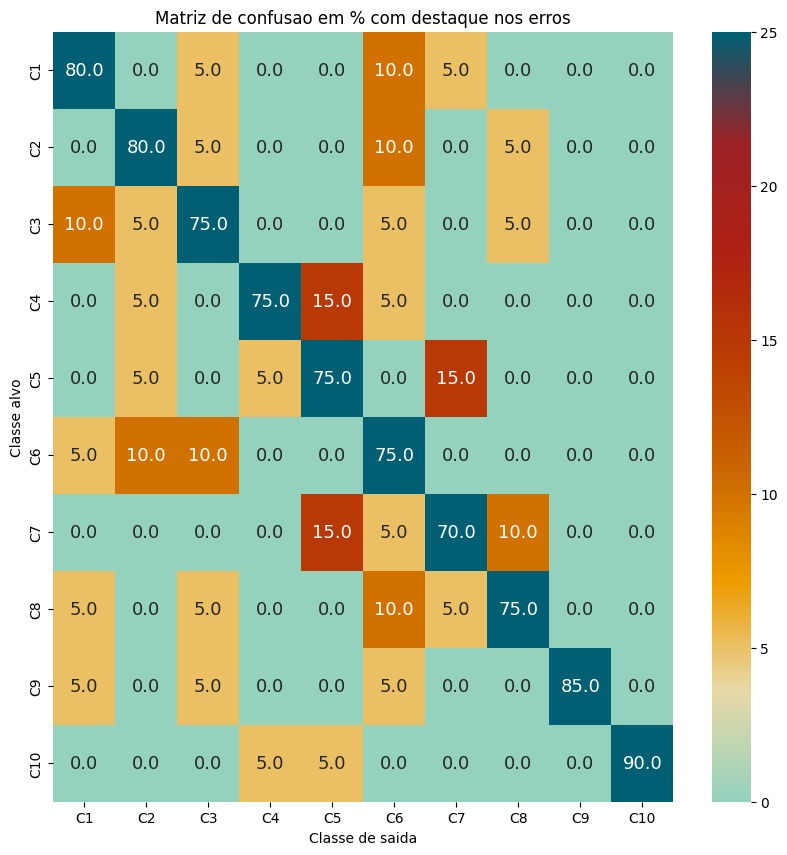

In [29]:
plt.figure(figsize=(10,10))
sn.heatmap(cf_geral*100/20,
           annot=True,
           fmt=".1f",
           annot_kws={"size": 13},
           xticklabels=classes,
           yticklabels=classes,
           cmap=cmap_error,
           vmin=0,
           vmax=25)

plt.title("Matriz de confusao em % com destaque nos erros")
plt.xlabel("Classe de saida")
plt.ylabel("Classe alvo")

plt.show()
# classe real e classe predita ( olhar os eixos se estao certos)

### Extraindo metricas da matriz

In [30]:
def printar_metrica(nome, metrica, metrica_porcentagem = None):
  df = pd.DataFrame({'classe': classes,
                      nome: metrica})

  if metrica_porcentagem is not None:
    df = pd.DataFrame({'classe': classes,
                        nome: metrica,
                        str(nome + "%"): metrica_porcentagem,})

  return df

In [31]:
cf_percent = cf_geral*100 / 20

####Falsos positivos (FP)
* Classificados como essa classe, mas eram de outra;
* Soma de cada coluna excluindo a diagonal principal.

In [32]:
FP = cf_geral.sum(axis=0) - np.diag(cf_geral)
FP_percent = np.round(cf_percent.sum(axis=0) - np.diag(cf_percent),2)

FP_table = printar_metrica("FP", FP, FP_percent)
FP_table.head(10)

classe    FP   FP%
0     C1   5.0  25.0
1     C2   5.0  25.0
2     C3   6.0  30.0
3     C4   2.0  10.0
4     C5   7.0  35.0
5     C6  10.0  50.0
6     C7   5.0  25.0
7     C8   4.0  20.0
8     C9   0.0   0.0
9    C10   0.0   0.0

#### Falsos negativos (FN)
* Classificados como essa classe, mas eram de outra;
* Soma de cada linha excluindo a diagonal principal.

In [33]:
FN = cf_geral.sum(axis=1) - np.diag(cf_geral)
FN_percent = np.round(cf_percent.sum(axis=1) - np.diag(cf_percent),2)

FN_table = printar_metrica("FN", FN, FN_percent)
FN_table.head(10)

classe   FN   FN%
0     C1  4.0  20.0
1     C2  4.0  20.0
2     C3  5.0  25.0
3     C4  5.0  25.0
4     C5  5.0  25.0
5     C6  5.0  25.0
6     C7  6.0  30.0
7     C8  5.0  25.0
8     C9  3.0  15.0
9    C10  2.0  10.0

####Verdadeiros Positivos (TP)
* acurácia para cada classe

In [34]:
TP = np.diag(cf_geral)
TP_percent = np.round(np.diag(cf_percent),2)

TP_table = printar_metrica("TP", TP, TP_percent)
TP_table.head(10)

classe    TP   TP%
0     C1  16.0  80.0
1     C2  16.0  80.0
2     C3  15.0  75.0
3     C4  15.0  75.0
4     C5  15.0  75.0
5     C6  15.0  75.0
6     C7  14.0  70.0
7     C8  15.0  75.0
8     C9  17.0  85.0
9    C10  18.0  90.0

#### Verdadeiros Negativos (TN):
 * Instâncias das outras classes preditas como outras classes.
 * Erros não importam desde que a classe em questão não esteja envolvida

In [35]:
TN = cf_geral.sum() - (FP + FN + TP)

TN_table = printar_metrica("TN", TN)
TN_table.head(10)

classe     TN
0     C1  175.0
1     C2  175.0
2     C3  174.0
3     C4  178.0
4     C5  173.0
5     C6  170.0
6     C7  175.0
7     C8  176.0
8     C9  180.0
9    C10  180.0

#### Sensitividade

sensitividade mede a proporção de positivos do total (acurácia?)

In [36]:
sensitividade = TP/(TP+FN)

sensitividade_table = printar_metrica("Sensitividade", sensitividade*100)
sensitividade_table.head(10)

classe  Sensitividade
0     C1           80.0
1     C2           80.0
2     C3           75.0
3     C4           75.0
4     C5           75.0
5     C6           75.0
6     C7           70.0
7     C8           75.0
8     C9           85.0
9    C10           90.0

#### Especificidade

Quantifica a proporção de TN classificados corretamente, pode ser vista como a tava de TN (TNR)

In [37]:
especificidade = TN/(TN+FP)

especificidade_table = printar_metrica("Especificidade", np.round(especificidade,3))
especificidade_table.head(10)

classe  Especificidade
0     C1           0.972
1     C2           0.972
2     C3           0.967
3     C4           0.989
4     C5           0.961
5     C6           0.944
6     C7           0.972
7     C8           0.978
8     C9           1.000
9    C10           1.000

#### Precisão

In [38]:
precisao = TP/(TP+FP)

precisao_table = printar_metrica("Precisao", np.round(precisao,3))
precisao_table.head(10)

classe  Precisao
0     C1     0.762
1     C2     0.762
2     C3     0.714
3     C4     0.882
4     C5     0.682
5     C6     0.600
6     C7     0.737
7     C8     0.789
8     C9     1.000
9    C10     1.000

#### F1 Score

In [39]:
recall = sensitividade
F1_score = 2* (precisao*recall/(precisao + recall))

F1_table = printar_metrica("F1", np.round(F1_score,3))
F1_table.head(10)

classe     F1
0     C1  0.780
1     C2  0.780
2     C3  0.732
3     C4  0.811
4     C5  0.714
5     C6  0.667
6     C7  0.718
7     C8  0.769
8     C9  0.919
9    C10  0.947

##### F1 Score Macro
* media dos F1 Scores

In [40]:
F1_macro = np.mean(F1_score)
round(F1_macro,3)

0.784

##### F1 Score Micro

* Computa um F1 medio global, somando todos os TP, FN e FP e colocando na formula do F1

In [41]:
sum_recall = np.sum(recall)
sum_precisao = np.sum(precisao)

#F1_micro = 2 * (np.sum(recall)*np.sum(precisao) / (np.sum(recall)+np.sum(precisao)))/10
F1_micro = np.sum(TP)/(np.sum(TP)+ (0.5*(np.sum(FP)+np.sum(FN))))
round(F1_micro,3)

0.78

###Comparar resultados

In [42]:
labels_test_all2 = np.array(labels_test_all).flatten()
labels_test_all2.shape

(200,)

In [43]:
y_pred_all2 = np.array(y_pred_all).flatten()
y_pred_all2.shape

(200,)

In [44]:
np.unique(y_pred_all2)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [45]:
dict_metrics = classification_report(y_pred_all2, labels_test_all2,labels = np.unique(y_pred_all2), target_names=classes, output_dict=True)

In [46]:
dict_metrics["C2"]

{'precision': 0.8,
 'recall': 0.7619047619047619,
 'f1-score': 0.7804878048780488,
 'support': 21}

In [47]:
F1_score[1]

0.7804878048780488

In [48]:
precisao

array([0.76190476, 0.76190476, 0.71428571, 0.88235294, 0.68181818,
       0.6       , 0.73684211, 0.78947368, 1.        , 1.        ])

In [49]:
precisao_c1 = TP[0]/(TP[0]+FP[0])
recall_c1 = TP[0]/(TP[0]+FN[0])

f1_c1 = 2*(precisao_c1*recall_c1/(precisao_c1+recall_c1))
f1_c1

0.7804878048780488

In [50]:
precisao_c1

0.7619047619047619

In [51]:
especificidade

array([0.97222222, 0.97222222, 0.96666667, 0.98888889, 0.96111111,
       0.94444444, 0.97222222, 0.97777778, 1.        , 1.        ])

###Spider-Plot

In [52]:
df_metricas = pd.DataFrame(dict(
    porcentagem=[
       np.mean(accuracys)*100,
       np.mean(top_2k)*100,
       np.mean(top_3k)*100,
       np.mean(top_5k)*100,
       np.mean(sensitividade)*100,
       np.mean(especificidade)*100,
       np.mean(F1_micro)*100,
       np.mean(F1_macro)*100],
    metricas=['Accuracy','Top 2k','Top 3k','Top 5k','Sensitividade','Especificidade','F1 Micro', 'F1 Macro']))

fig = go.Figure()

fig = fig.add_trace(go.Scatterpolar(
        name = "Metricas",
        r = df_metricas['porcentagem'],
        theta = df_metricas['metricas'],

    ))
fig.update_layout(polar=dict(radialaxis=dict(visible=True,)),
                  showlegend=True,
                  title='Métricas em Porcentagem',
                  titlefont={'size': 28, 'family':'Serif'},
                  template='plotly_dark',
                  paper_bgcolor='gray',
                  width=600, height=500,
                  font=dict(
                  size=15,
                 ))
fig.update_traces(fill='toself')
fig.show()

###Histograma de probabilidade Geral

mostra a quantidade de imagens que foram classificadas com determinada certeza.

In [53]:
# prever uma unica imagem
model.predict(np.array([trainingImages[0]]))

1/1 [==============================] - 0s 208ms/step


array([[8.4444368e-01, 1.0451804e-01, 4.6005990e-02, 7.0103006e-06,
        3.7222442e-06, 2.2217690e-03, 1.1382257e-07, 2.7151846e-03,
        5.2386852e-11, 8.4587016e-05]], dtype=float32)

In [54]:
proba = []
true_class = [] # pegar a classe verdadeira
pred_class = [] # pegar a classe predita
for (train_index, test_index) in skf.split(trainingImages, labels):
  predicted = model.predict(np.array(trainingImages[test_index])) #pegar prob das imagens de teste desse fold
  proba.append(predicted)
  pred_class.append(np.argmax(predicted, axis=1))
  true_class.append(labels[test_index])

2/2 [==============================] - 0s 9ms/step


In [55]:
#pegar as imagens de teste de cada fold e ver as probabilidades
labels_test_all = np.array(labels_test_all) # true labels
y_pred_prob = np.array(y_pred_prob) # probabilities for all test images
y_pred_all = np.array(y_pred_all) # labels pred

In [56]:
max_proba = np.max(y_pred_prob, axis = 2).flatten()

Text(0, 0.5, 'Quantidade de imagens')

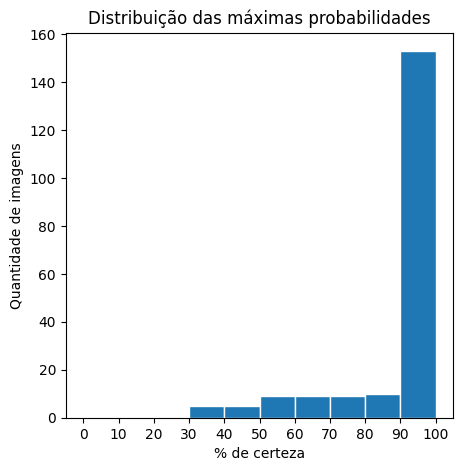

In [57]:
plt.rcParams["figure.figsize"] = [5, 5]
bins=np.arange(0, 101, 10)
plt.hist(max_proba * 100, bins=bins, edgecolor='w')
plt.xticks(bins);
plt.title("Distribuição das máximas probabilidades")
plt.xlabel("% de certeza")
plt.ylabel("Quantidade de imagens")

In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred_all.flatten(), labels_test_all.flatten())

0.78

### Recuperação de imagens

In [59]:
def plot_images(N, images, labels_pred, labels_true):
  # plotar as imagens, de N em N
  n_rows = images.shape[0]//N if images.shape[0] % N == 0 else images.shape[0]//N + 1
  n_columns = N

  plt.rcParams["figure.figsize"] = [20, n_rows*5]
  plt.rcParams["figure.autolayout"] = True
  plt.subplot()

  for i in range(images.shape[0]):
    plt.subplot(n_rows, n_columns, i+1);
    plt.imshow(images[i]);
    plt.title(f"C{labels_pred[i]+1} era C{labels_true[i]+1}")

In [60]:
# imagens que errou a classificação
img_pred_wrong = trainingImages[labels_test_all.flatten() != y_pred_all.flatten()]
print(f"Errou {img_pred_wrong.shape[0]} imagens")

Errou 44 imagens


In [61]:
labels_pred = y_pred_all[labels_test_all != y_pred_all].flatten()
labels_true = labels_test_all[labels_test_all != y_pred_all].flatten()

<ipython-input-59-c7bde3e069db>:11: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



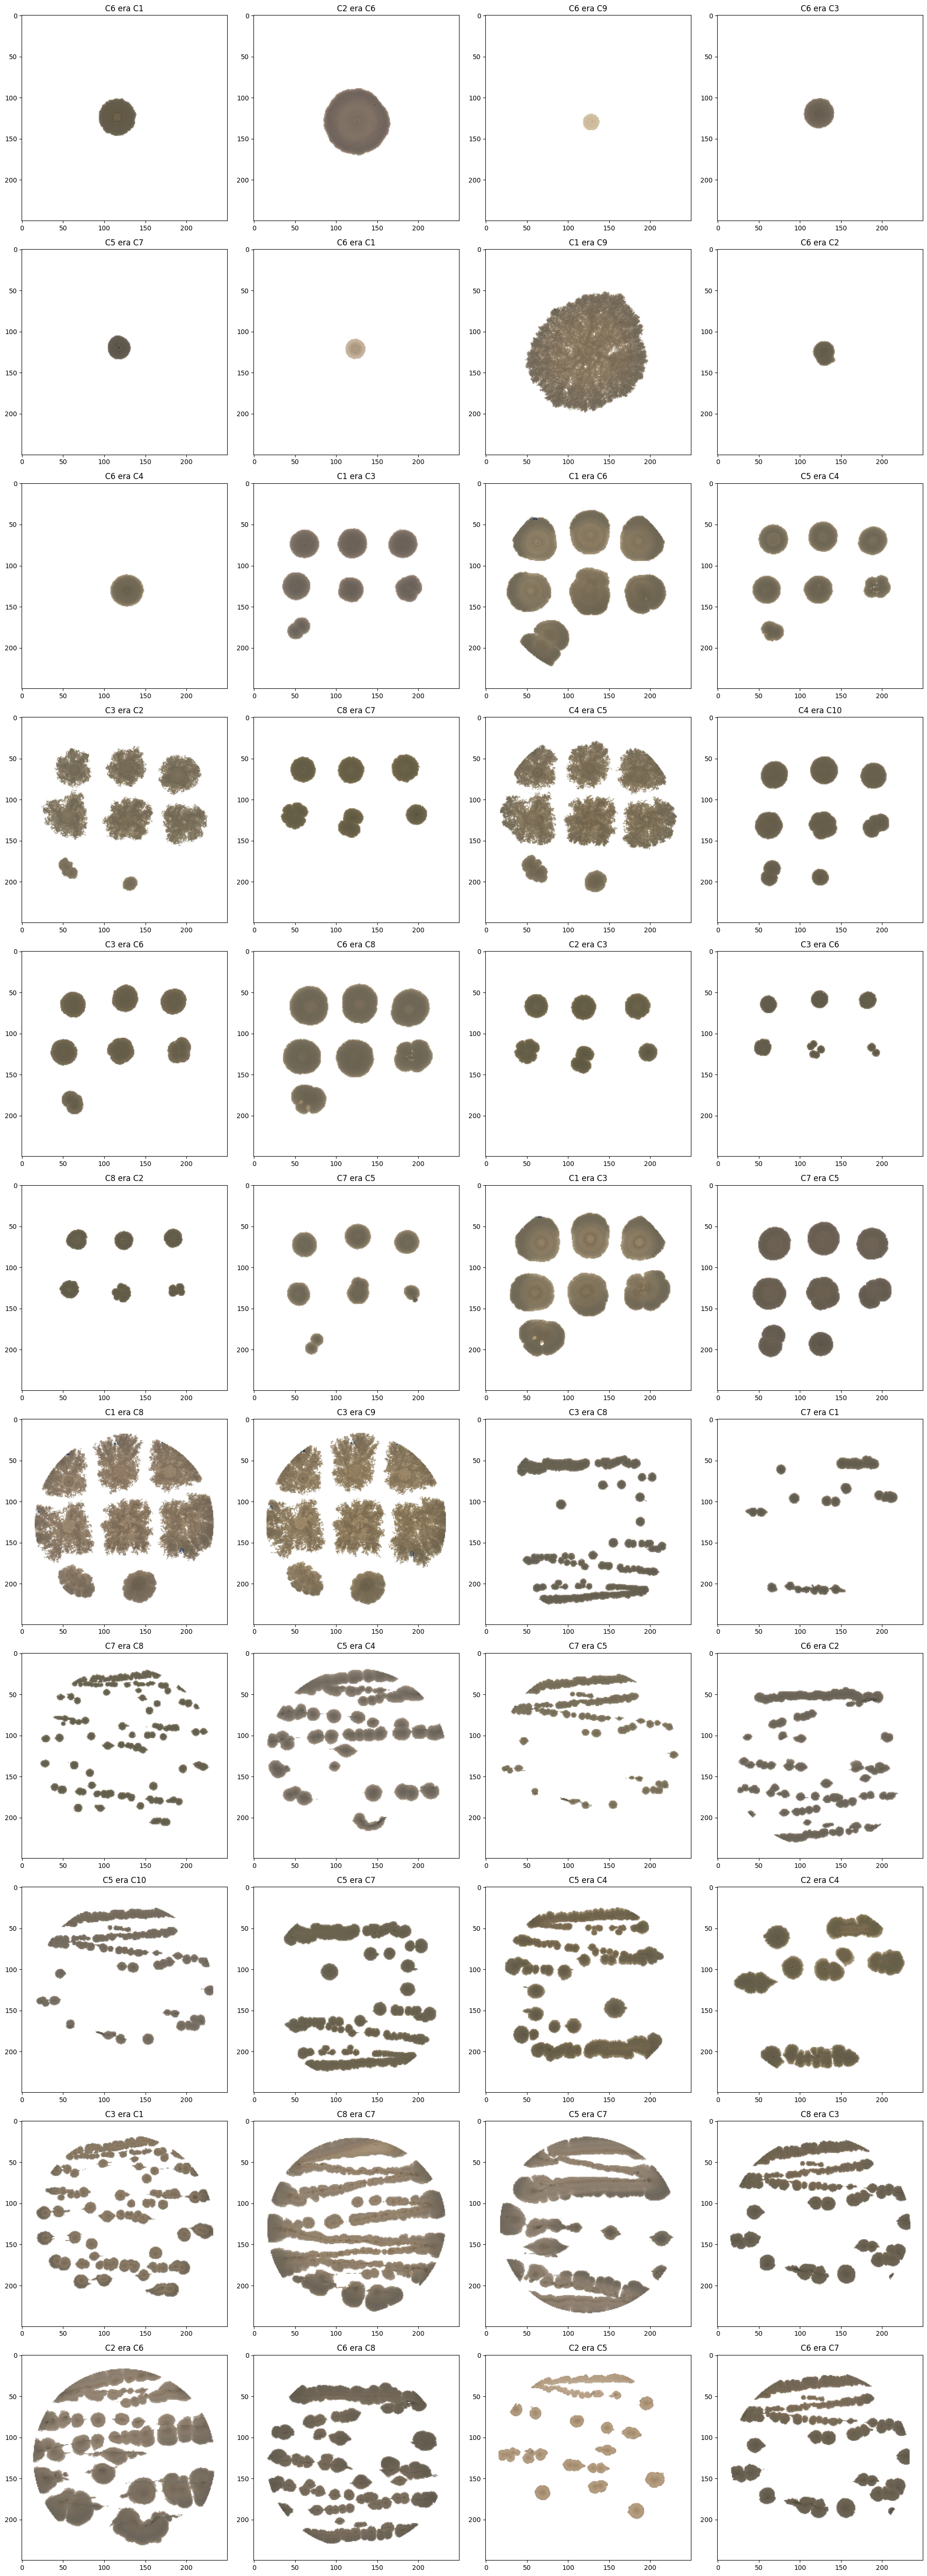

In [62]:
plot_images(4, img_pred_wrong, labels_pred, labels_true)

#### Imagens em que teve mais dúvida

In [63]:
# teve mais dúvida (menos de "proba"% de probabilidade de ser da classe alvo segundo o modelo)
proba = 0.5
index_of_proba = max_proba < proba
img_duvida = trainingImages[max_proba < 0.5]
print(f"Duvida em {img_duvida.shape[0]} imagens")

Duvida em 10 imagens


In [64]:
labels_pred = y_pred_all.flatten()[index_of_proba]
labels_true = labels_test_all.flatten()[index_of_proba]

In [65]:
print(labels_pred)
print(labels_true)

[1 5 5 0 5 5 2 6 6 4]
[5 8 2 8 3 7 7 0 7 6]


In [66]:
print(f'Acurácia entre as que teve dúvida {round(accuracy_score(labels_true, labels_pred),2)*100}%')

Acurácia entre as que teve dúvida 0.0%


<ipython-input-59-c7bde3e069db>:11: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



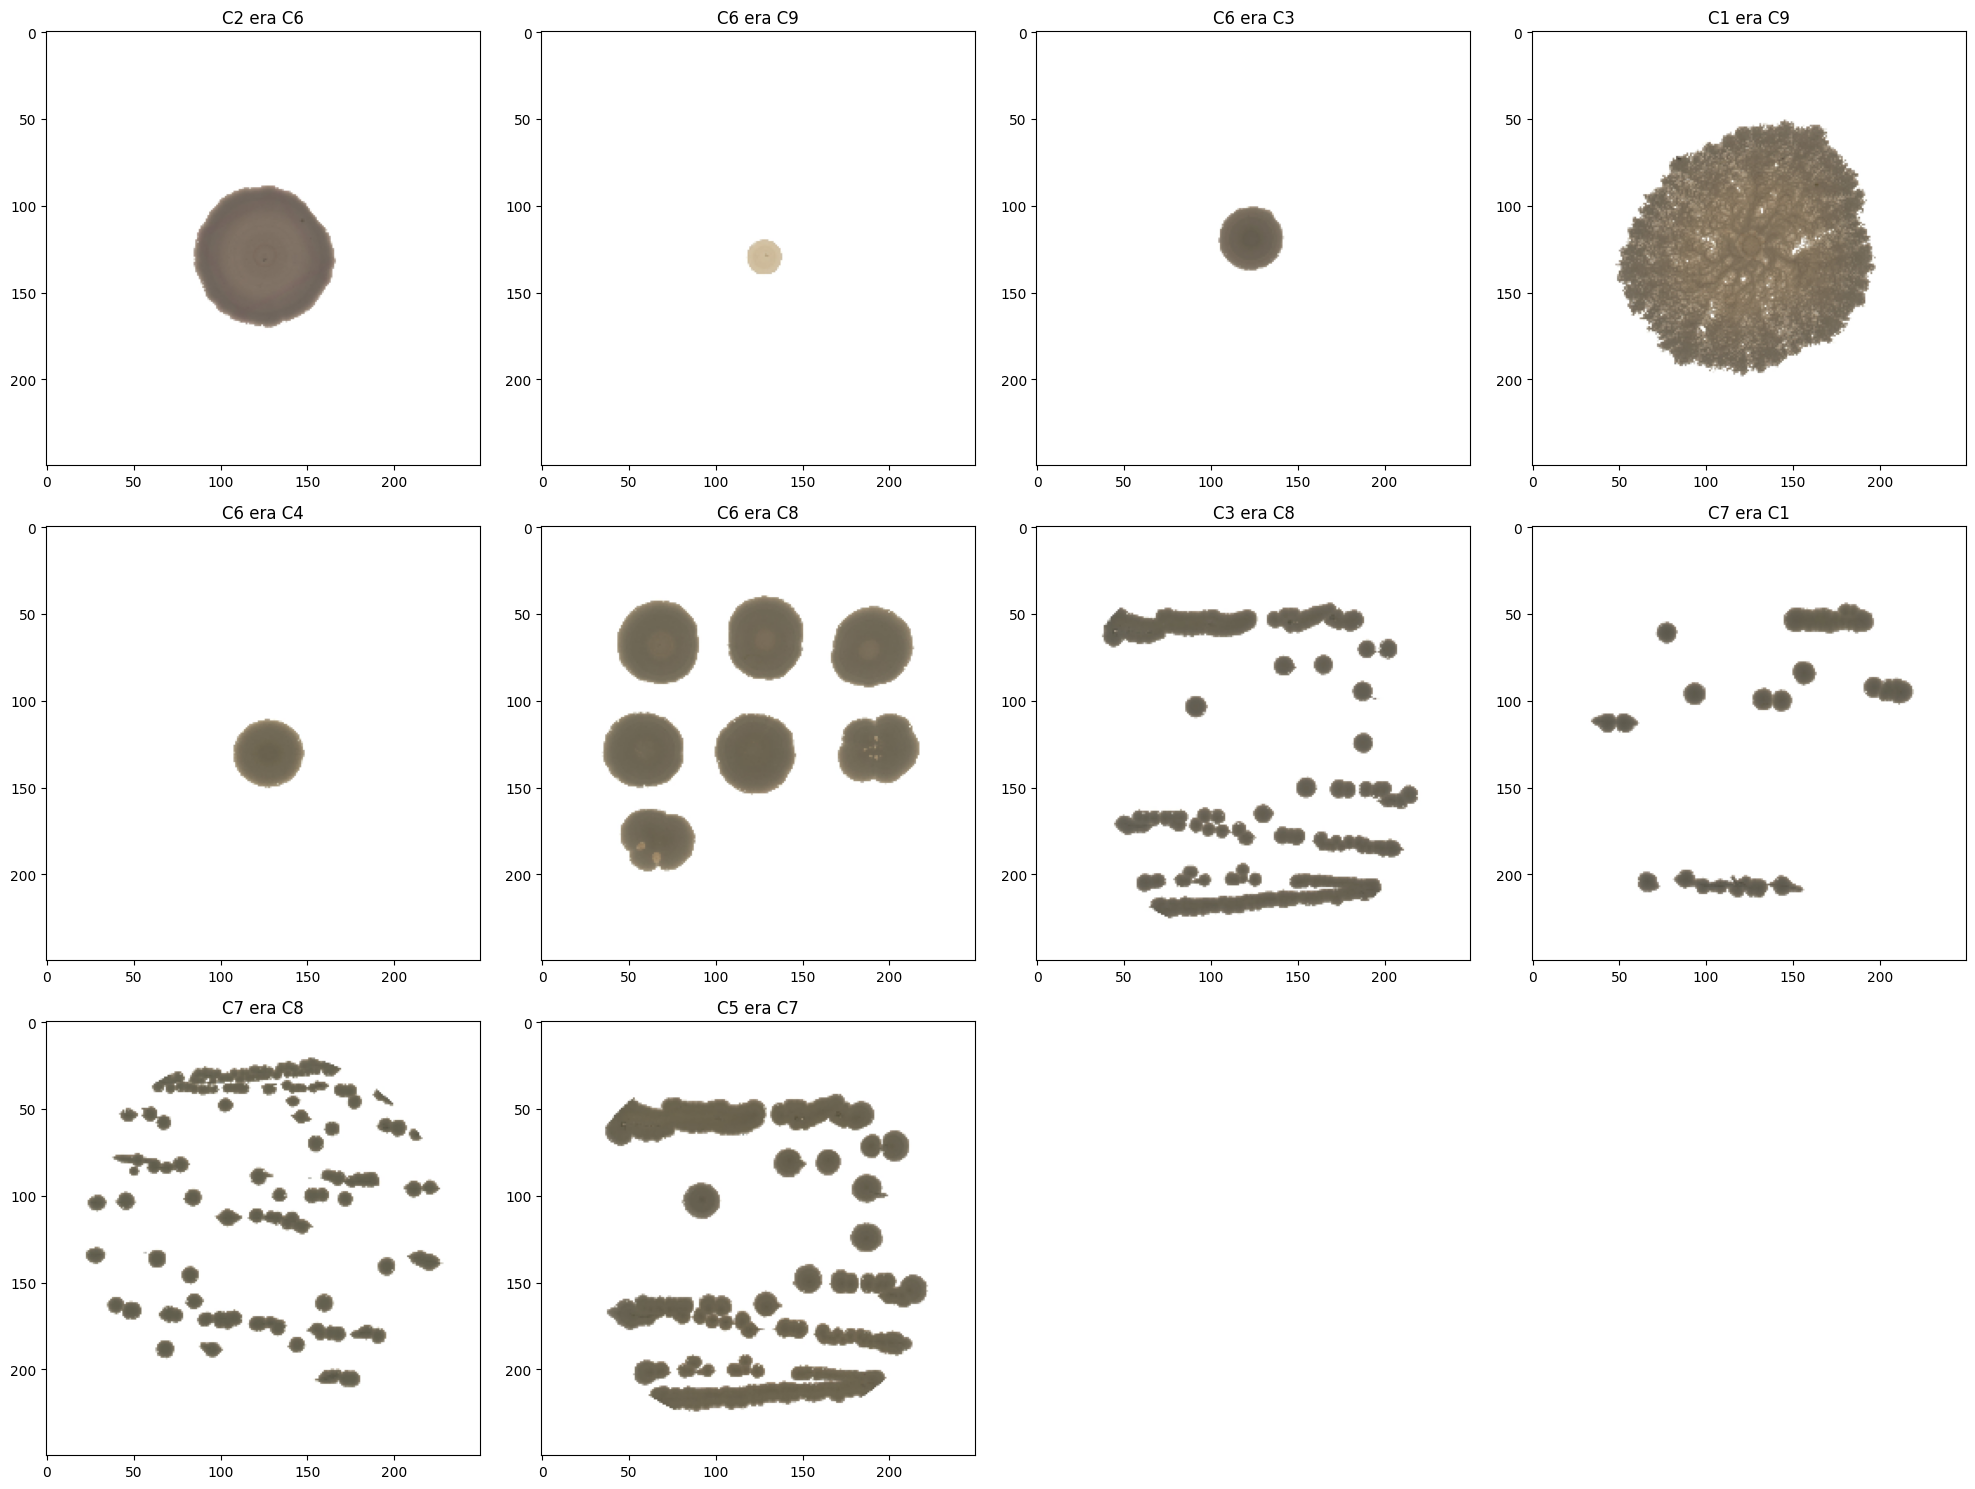

In [67]:
plot_images(4, img_duvida, labels_pred, labels_true)

###Histogramas por classe

In [68]:
labels_test_all = np.array(labels_test_all) # true labels
y_pred_prob = np.array(y_pred_prob) # probabilities for all test images
y_pred_all = np.array(y_pred_all) # labels pred

In [69]:
plt.rcParams["figure.figsize"] = [5, 5]

In [70]:
y_pred_prob.shape

(5, 40, 10)

In [71]:
max_proba.shape

(200,)

In [72]:
y_pred.shape

(40, 10)

[  0  10  20  30  40  50  60  70  80  90 100]


<ipython-input-73-605c5ea2592b>:15: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



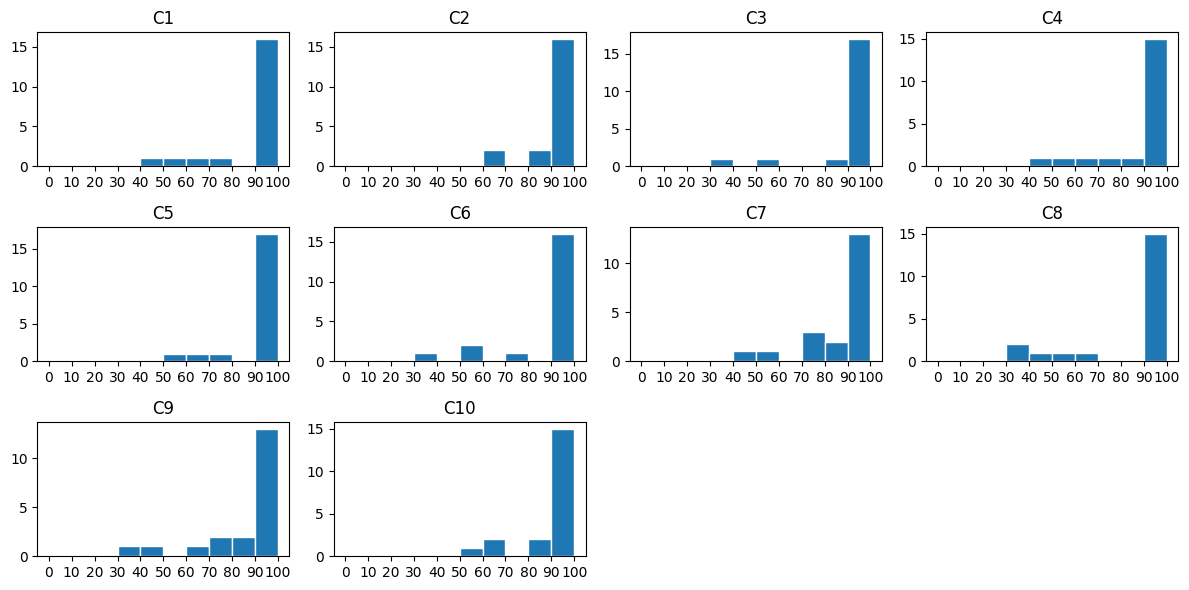

In [73]:
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.autolayout"] = True
plt.subplot()

y_true = labels_test_all.flatten()
y_pred = y_pred_prob.flatten()*100
class_histogram = np.zeros((10,10))

bins=np.arange(0, 101, 10)
print(bins)
for i in range(10):
  indexes_class = np.where(y_true == i)[0]
  # np.digitize(y_pred[indexes_class],bins)
  # class_histogram
  plt.subplot(3, 4, i+1)
  plt.hist(max_proba[indexes_class]*100,  bins=bins, edgecolor='w');
  plt.xticks(bins);
  plt.title(f"C{i+1}")

### SHAP

In [74]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.6 MB/s eta 0:00:00


In [75]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


ver o problema do input shape (espera que seja uma imagem 3d)
* procurar se tem alguma implementada para 2d;
* testar se adicionar mais uma dimensao com 0 faz efeito;
* usar as imagens 3d para treinar o modelo;
* ver se e possivel modificar a funcao da biblioteca para rodar em 2d

In [76]:
x_train = np.copy(trainingImages)
x_train.shape

(200, 250, 250, 3)

[masker](https://shap.readthedocs.io/en/latest/generated/shap.maskers.Image.html)

In [77]:
# This masks out image regions with blurring or inpainting.
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
# masker = shap.maskers.Image("inpaint_telea", x_train[0].shape)
masker = shap.maskers.Image("blur(128,128)", x_train[0].shape)

In [78]:
# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(model, masker, output_names = classes)

In [79]:
# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(x_train[110:115], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 6it [00:22,  5.72s/it]


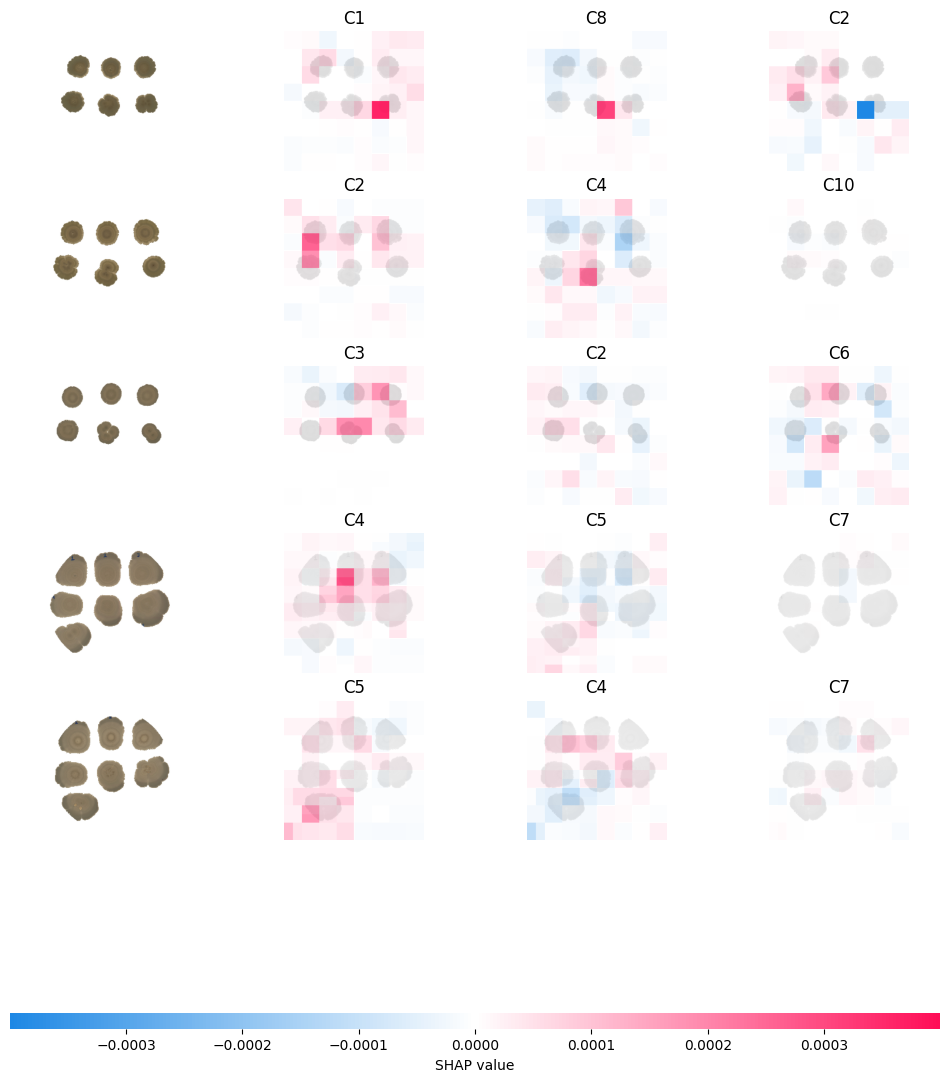

In [80]:
plt.style.use('default')
shap.image_plot(shap_values)

In [81]:
indexes = np.array([110, 110, 130])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


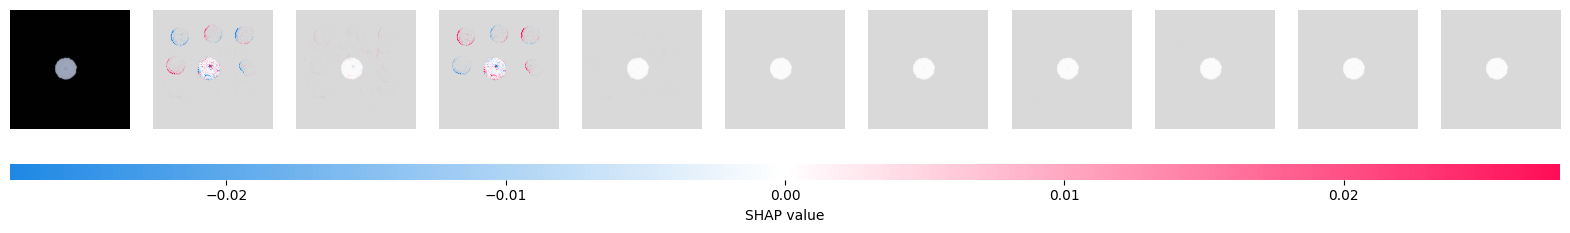

In [82]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 20, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_train[0:1], check_additivity = False)

# plot the feature attributions
shap.image_plot(shap_values, -x_train[0:1])

### LIME

https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html

In [84]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283838 sha256=c7756e1c54027688f2cdf8537dc50ba6eb587ede7a82ef456374b44ac59969b5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [85]:
from lime import lime_image
import time

In [86]:
explainer = lime_image.LimeImageExplainer()

In [144]:
image = x_train[110] # get one image to be explained

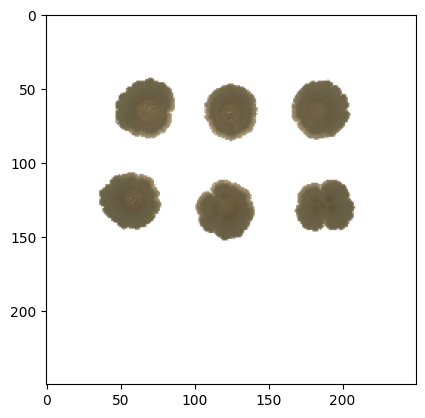

In [145]:
plt.imshow(image)

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [166]:
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image, model.predict, top_labels=5, hide_color=0, num_samples=1000)
print(time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step
19.437493085861206


In [167]:
# see the explanation for the top class
from skimage.segmentation import mark_boundaries

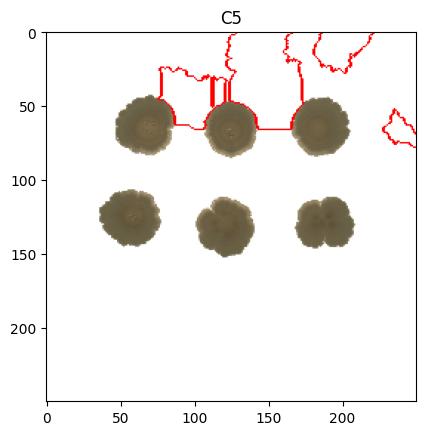

In [168]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.title(classes[explanation.top_labels[0]])
plt.imshow(mark_boundaries(temp, mask, color=(255,0,0)))

mostrar mais features (porem não são de tanta relevância)

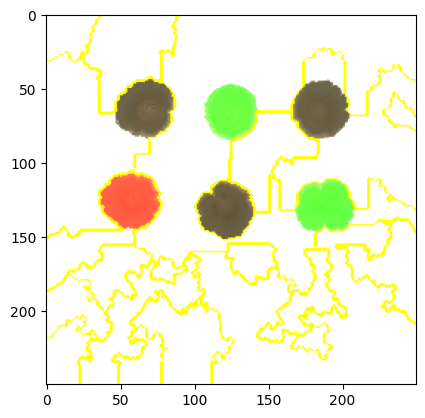

In [176]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=40, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Outra imagem

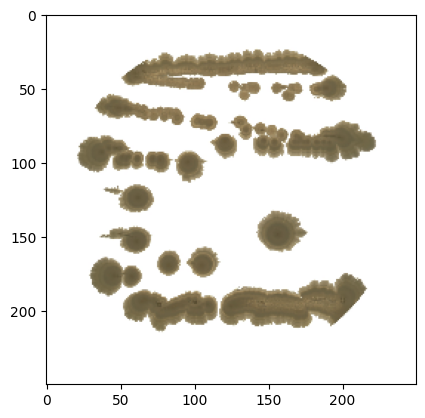

In [149]:
image2 = x_train[190]
plt.imshow(image2)

In [150]:
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image2, model.predict, top_labels=5, hide_color=0, num_samples=1000)
print(time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
12.330497026443481


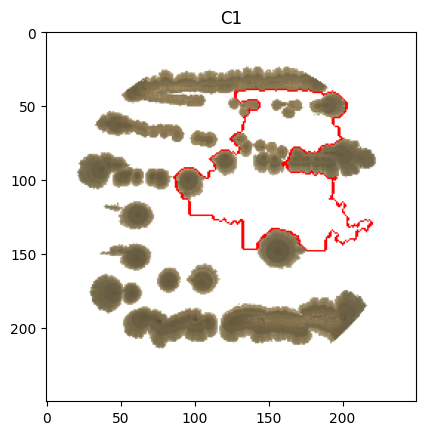

In [151]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.title(classes[explanation.top_labels[0]])
plt.imshow(mark_boundaries(temp, mask, color=(255,0,0)))

### GRAD-CAM

### Leave one out

In [156]:
# equivalete a KFold(n_splits=n)

In [157]:
from sklearn.model_selection import LeaveOneOut

In [158]:
n = 200

y_pred = []
y_true = []

cv = LeaveOneOut()
k = 0

In [160]:
for train_ix, test_ix in cv.split(trainingImages):

  X_train, X_test = trainingImages[train_ix, :], trainingImages[test_ix, :]
  y_train, y_test = labels[train_ix], labels[test_ix]

  model = simple_dl()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics= metrics)

  #modelo com os mesmos hiperparametros
  model.fit(X_train,
            y_train,
            epochs=80,
            callbacks=[callback, cp_callback],
            batch_size=64,
            verbose=False)

  #loss, accuracys, top_2k, top_3k, top_5k = model.evaluate(X_test, y_test)

  y_pred.append(model.predict(X_test)[0])
  y_true.append(y_test[0])
  k += 1

In [163]:
# transformando em numpy array
y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_pred.shape

(0,)

Pegar a posição cuja probabilidade é a maior (argmax)

In [162]:
y_pred = np.argsort(y_pred, axis=1)[:,-1]

AxisError: ignored

Checando a acurácia

In [ ]:
acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

matriz de confusao

In [ ]:
cf_matrix = tf.math.confusion_matrix(
            y_true,
            y_pred,
            num_classes=None,
            weights=None,
            dtype=float,
            name=None
            )

In [ ]:
plt.figure(figsize=(10,10))
sn.heatmap(cf_matrix*100/20,
           annot=True,
           fmt=".2f",
           annot_kws={"size": 13},
           xticklabels=classes,
           yticklabels=classes,
           cmap=cmap_error,
           vmin=0,
           vmax=30)

plt.title("Matriz de confusao do Leave One Out em % com destaque nos erros")
plt.xlabel("Classe de saida")
plt.ylabel("Classe alvo")

plt.show()
# classe real e classe predita ( olhar os eixos se estao certos)

In [ ]:
pip install lime

In [ ]:
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
plt.rcParams["figure.figsize"] = [5,5]
plt.imshow(trainingImages[max_proba < 0.5][0], cmap="gray")

In [ ]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
# image -> image to be explained
# predict_fn -> probabilidades
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)